# 6 – Flat Cortex Surfaces  
Visualize RSA cortical maps on flattened surfaces using PyCortex.

For running this notebook, you need to have the `pycortex` package installed and inkscape available in your PATH.

In [ ]:
import mne
import cortex
import numpy as np
from pathlib import Path
from convergence.figures_utils import proccess_alignment
from convergence.figures import setup_matplotlib_fonts, plot_cbar_set

setup_matplotlib_fonts()

## 6.1 Data Paths  
Define and validate all file paths needed for loading HCP metadata and RSA results, and set up the output directory.


In [2]:

data_folder = Path("../derivatives")
hcp_filename = data_folder / "metadata" / "hcp.csv"
models_filename = data_folder / "metadata" / "models-info.csv"
nsd_folder = data_folder / "nsd"
pvalues_filename = nsd_folder / "rsa_pvalues_subject_language_vision.parquet"
intersubject_shift1_separated_filename = (
    nsd_folder / "rsa_subject_subject_alignment_shift_1_separated.parquet"
)
model_brain_separated_filename = nsd_folder / "rsa_subject_model_alignment_separated.parquet"

# Output folder for figures
figure_folder = Path("../figures")
output = figure_folder / "06_rsa_flat_surfaces"
output.mkdir(exist_ok=True, parents=True)

## 6.2 Helper Functions  
Load the HCP fsaverage parcel labels via MNE and assemble per‐vertex data arrays for PyCortex visualization.


In [3]:
def load_labels(subject="fsaverage"):

    subjects_dir = mne.datasets.sample.data_path() / "subjects"
    mne.datasets.fetch_hcp_mmp_parcellation(subjects_dir=subjects_dir, verbose=False)
    annot_lh = Path(subjects_dir, subject, "label", "lh.HCPMMP1.annot")
    annot_rh = Path(subjects_dir, subject, "label", "rh.HCPMMP1.annot")
    assert annot_lh.exists() and annot_rh.exists(), "HCPMMP1 annot missing"

    labels_lh = mne.read_labels_from_annot(
        subject,
        parc="HCPMMP1",
        hemi="lh",
        subjects_dir=subjects_dir,
        sort=True,
        verbose=False,
    )
    labels_rh = mne.read_labels_from_annot(
        subject,
        parc="HCPMMP1",
        hemi="rh",
        subjects_dir=subjects_dir,
        sort=True,
        verbose=False,
    )
    return subject, labels_lh, labels_rh


def get_vertex(
    df,
    value_column="score",
    mne_name_column="mne_name",
    subject="fsaverage",
    vmin=0,
    vmax=1,
    cmap="RdBu_r",
    default_value=0,
):

    df_mne = df[[mne_name_column, value_column]].set_index(mne_name_column)
    df_mne = df_mne.rename(columns={value_column: "score"})

    subject, labels_lh, labels_rh = load_labels(subject)

    verts_lh = cortex.db.get_surf(subject, hemisphere="lh", type="inflated")[0].shape[0]
    verts_rh = cortex.db.get_surf(subject, hemisphere="lh", type="inflated")[0].shape[0]

    data_lh = default_value * np.ones(verts_lh)  # -1 = “no label”
    data_rh = default_value * np.ones(verts_rh)

    for _, lab in enumerate(labels_lh):
        name = lab.name  # print(idx, lab.name)
        if name not in df_mne.index:
            value = default_value
        else:
            value = df_mne.loc[name, "score"]

        data_lh[lab.vertices] = value
    for _, lab in enumerate(labels_rh):
        name = lab.name  # print(idx, lab.name)
        if name not in df_mne.index:
            value = default_value
        else:
            data_rh[lab.vertices] = df_mne.loc[name, "score"]

    vertex = cortex.Vertex(
        np.hstack([data_lh, data_rh]),
        subject=subject,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
    )
    return vertex

## 6.3 Load ROI Statistics  
Aggregate RSA scores and depth metrics per ROI across subjects for flatmap coloring.


In [4]:
df = proccess_alignment(
    models_filename=models_filename,
    models_alignment_filename=model_brain_separated_filename,
    subject_alignment_filename=intersubject_shift1_separated_filename,
    pvalues_filename=pvalues_filename,
    hcp_filename=hcp_filename,
    group_subject=True,
)

df.head()


,roi,intersubject_rsa,language_rsa,language_depth,vision_rsa,vision_depth,intersubject_p_value,intersubject_null_mean,intersubject_null_std,intersubject_apa_star,...,mne_name,roi_order,vision_p_value,vision_null_mean,vision_null_std,vision_apa_star,language_p_value,language_null_mean,language_null_std,language_apa_star
0,1,0.216566,-0.003411,0.426597,0.163170,0.193269,0.000161,9.465456e-06,0.003569,***,...,L_V1_ROI-lh,0,0.000103,0.000916,0.002052,***,0.351028,0.000711,0.002266,n.s.
1,2,0.131582,0.127652,0.554092,0.101820,0.781128,0.000161,6.518135e-06,0.002293,***,...,L_MST_ROI-lh,24,0.000103,0.000470,0.001593,***,0.000225,0.000365,0.001762,***
2,3,0.008578,0.011899,0.458930,0.045248,0.506478,0.000161,-3.537752e-06,0.001275,***,...,L_V6_ROI-lh,7,0.000103,0.000408,0.001456,***,0.000225,0.000316,0.001603,***
3,4,0.200117,-0.008663,0.414318,0.160414,0.200613,0.000161,9.280093e-07,0.003676,***,...,L_V2_ROI-lh,1,0.000103,0.000968,0.002073,***,0.000225,0.000737,0.002296,***
4,5,0.148561,-0.021737,0.381870,0.137458,0.220375,0.000161,2.677682e-05,0.003430,***,...,L_V3_ROI-lh,2,0.000103,0.001055,0.002085,***,0.000225,0.000802,0.002311,***


## 6.4 PyCortex Rendering Options  
Set common options for the flatmap figures: sulci, curvature, borders, ROI labels, and disable the built‑in colorbar.


In [5]:
pycortex_options = {"with_sulci": True, "with_curvature": True, 
                    "with_colorbar": False, "with_borders":True, 
                    "with_labels": True, "with_rois": True,
}

## 6.5 Inter‑Subject RSA Flatmap  
Render the shifted inter‑subject RSA map on a flat cortex.  

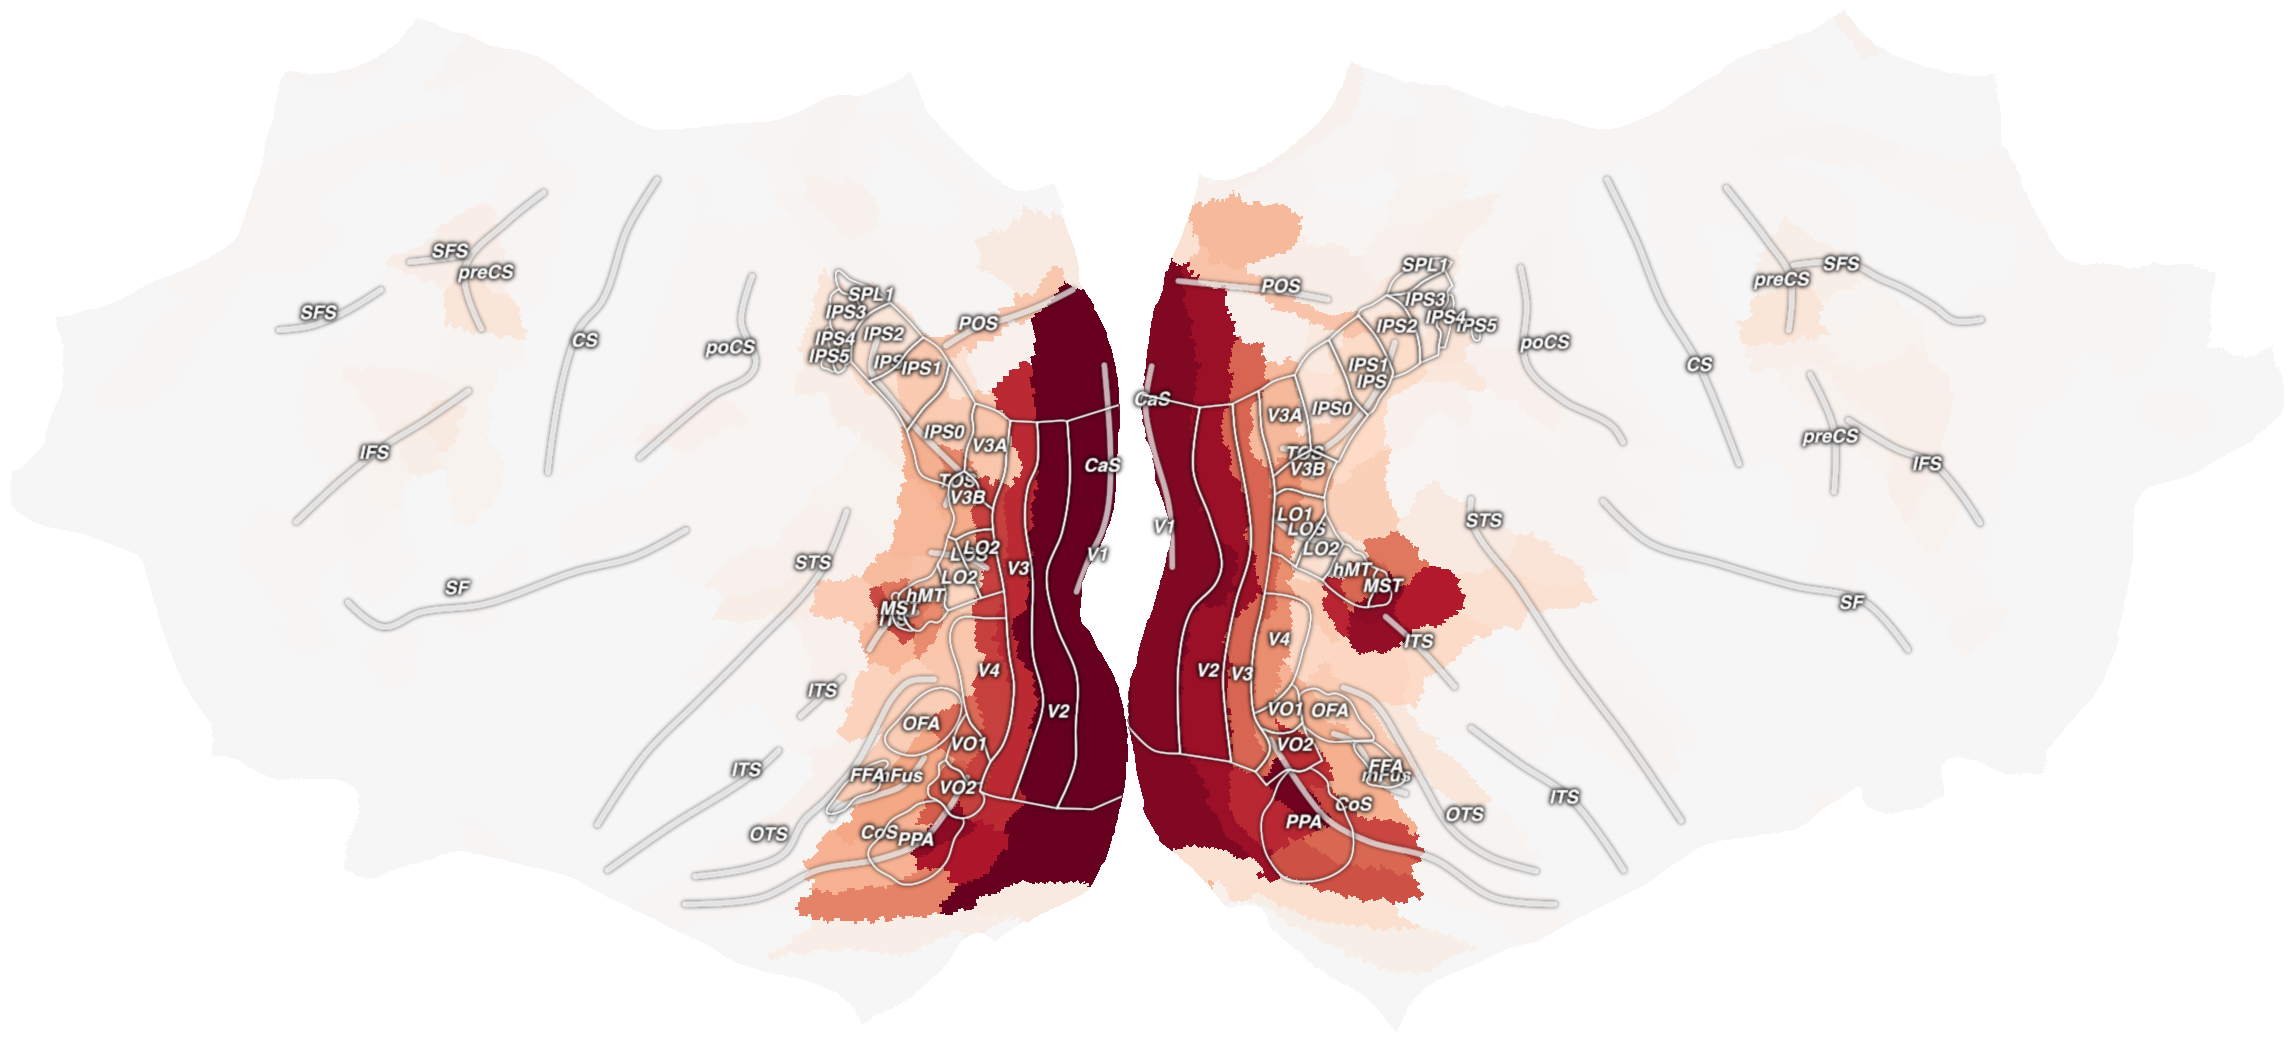

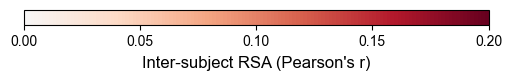

In [ ]:
vmax = 0.2
output_file = output / f"01_intersubject_surface_rsa_{vmax:.2f}.pdf"

# Plot and save the figure
vertex = get_vertex(df, value_column="intersubject_rsa", vmin=-vmax, vmax=vmax, cmap="RdBu_r")
fig = cortex.quickflat.make_figure(vertex, **pycortex_options)
fig.savefig(output_file, bbox_inches="tight", transparent=True)

# Save an associate colorbar
output_file = output / f"01_intersubject_surface_rsa_cbar_{vmax:.2f}.pdf"
title = "Inter-subject RSA (Pearson's r)"
plot_cbar_set(title=title, filename=output_file, vmax=vmax, vmin=0, locator=0.05)


## 6.6 Vision‑Model RSA Flatmap  
Show model–brain RSA for vision models on the flattened cortex.  


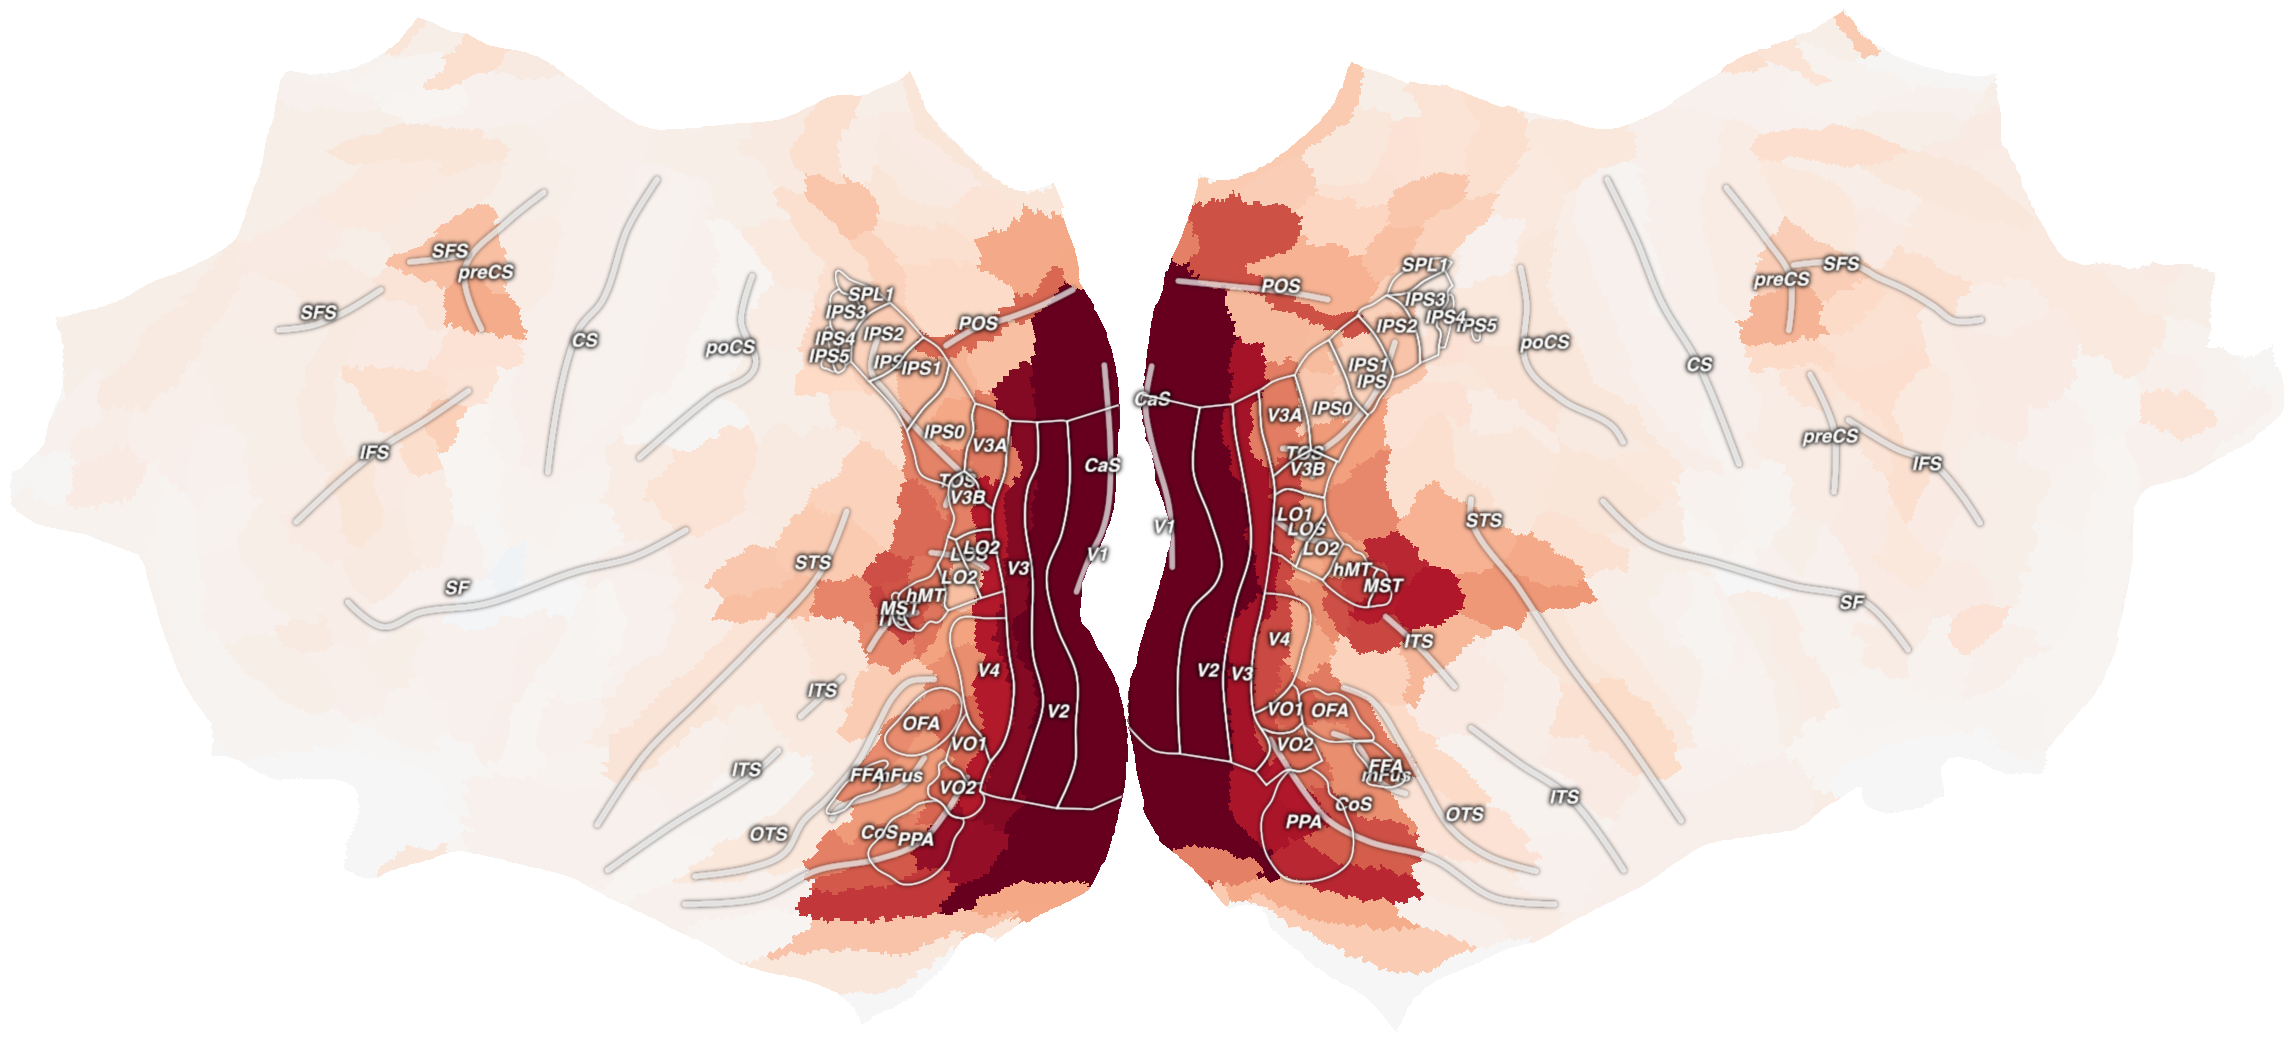

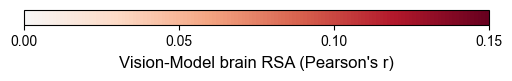

In [ ]:
vmax = 0.15
output_file = output / f"02_vision-model_surface_rsa_{vmax:.2f}.pdf"

# Plot and save the figure
vertex = get_vertex(df, value_column="vision_rsa", vmin=-vmax, vmax=vmax, cmap="RdBu_r")
fig = cortex.quickflat.make_figure(vertex, **pycortex_options)
fig.savefig(output_file, bbox_inches="tight", transparent=True)

# Save an associate colorbar
output_file = output / f"02_vision-model_rsa_cbar_{vmax:.2f}.pdf"
title = "Vision-Model brain RSA (Pearson's r)"
plot_cbar_set(title=title, filename=output_file, vmax=vmax, vmin=0, locator=0.05)


## 6.7 Language‑Model RSA Flatmap  
Render model–brain RSA for language models on the flat cortex.  


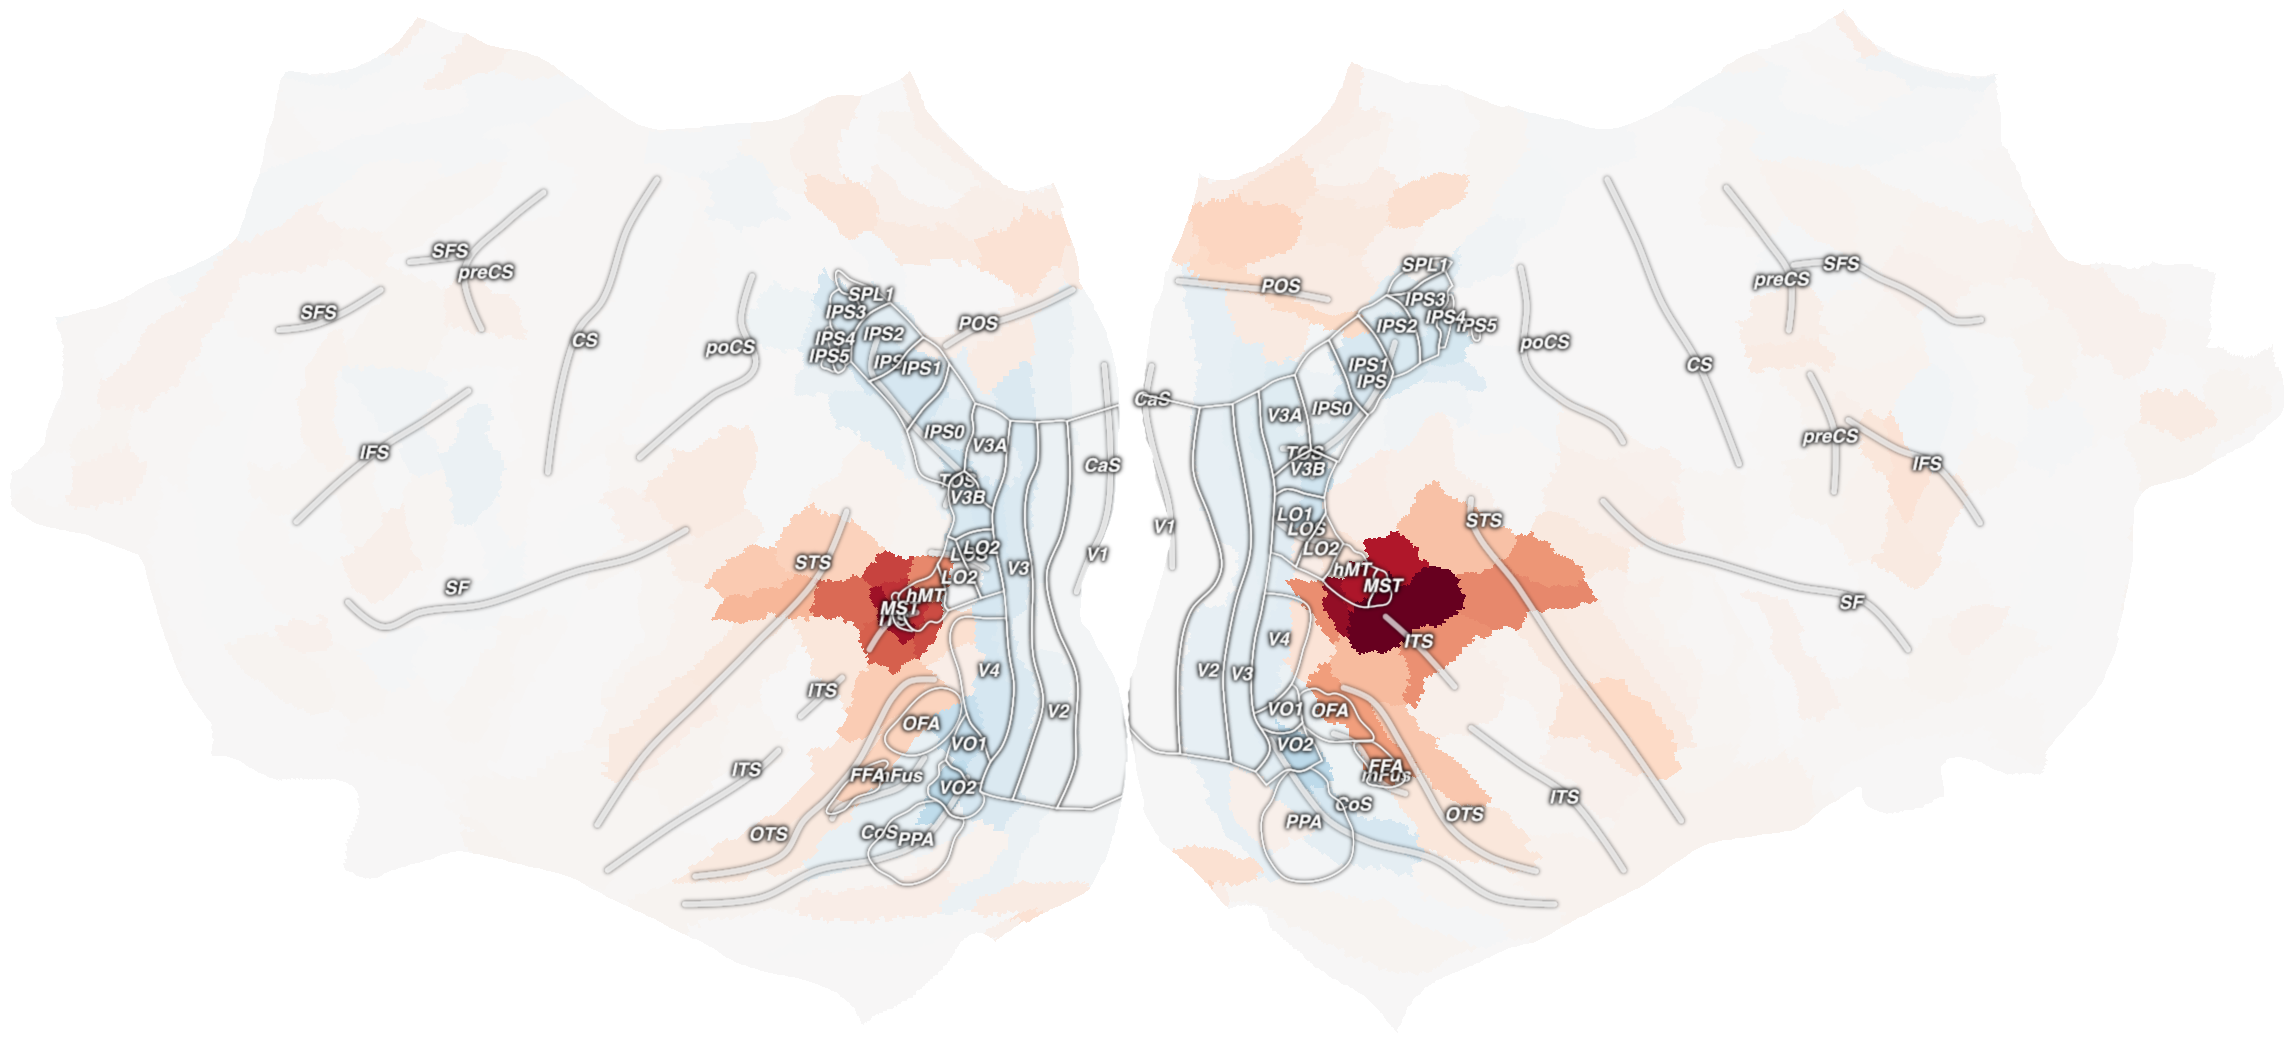

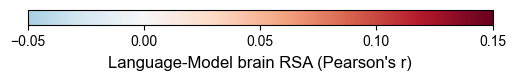

In [ ]:
vmax = 0.15
output_file = output / f"03_language-model_surface_rsa_{vmax:.2f}.pdf"

# Plot and save the figure
vertex = get_vertex(df, value_column="language_rsa", vmin=-vmax, vmax=vmax, cmap="RdBu_r")
fig = cortex.quickflat.make_figure(vertex, **pycortex_options)
fig.savefig(output_file, bbox_inches="tight", transparent=True)

# Save an associate colorbar
output_file = output / f"03_language-model_rsa_cbar_{vmax:.2f}.pdf"
title = "Language-Model brain RSA (Pearson's r)"
plot_cbar_set(title=title, filename=output_file, vmax=vmax, vmin=-0.05, locator=0.05)


## 6.8 Vision‑Model Convergence Depth Flatmap  
Visualize the normalized layer depth at peak alignment for vision models.  


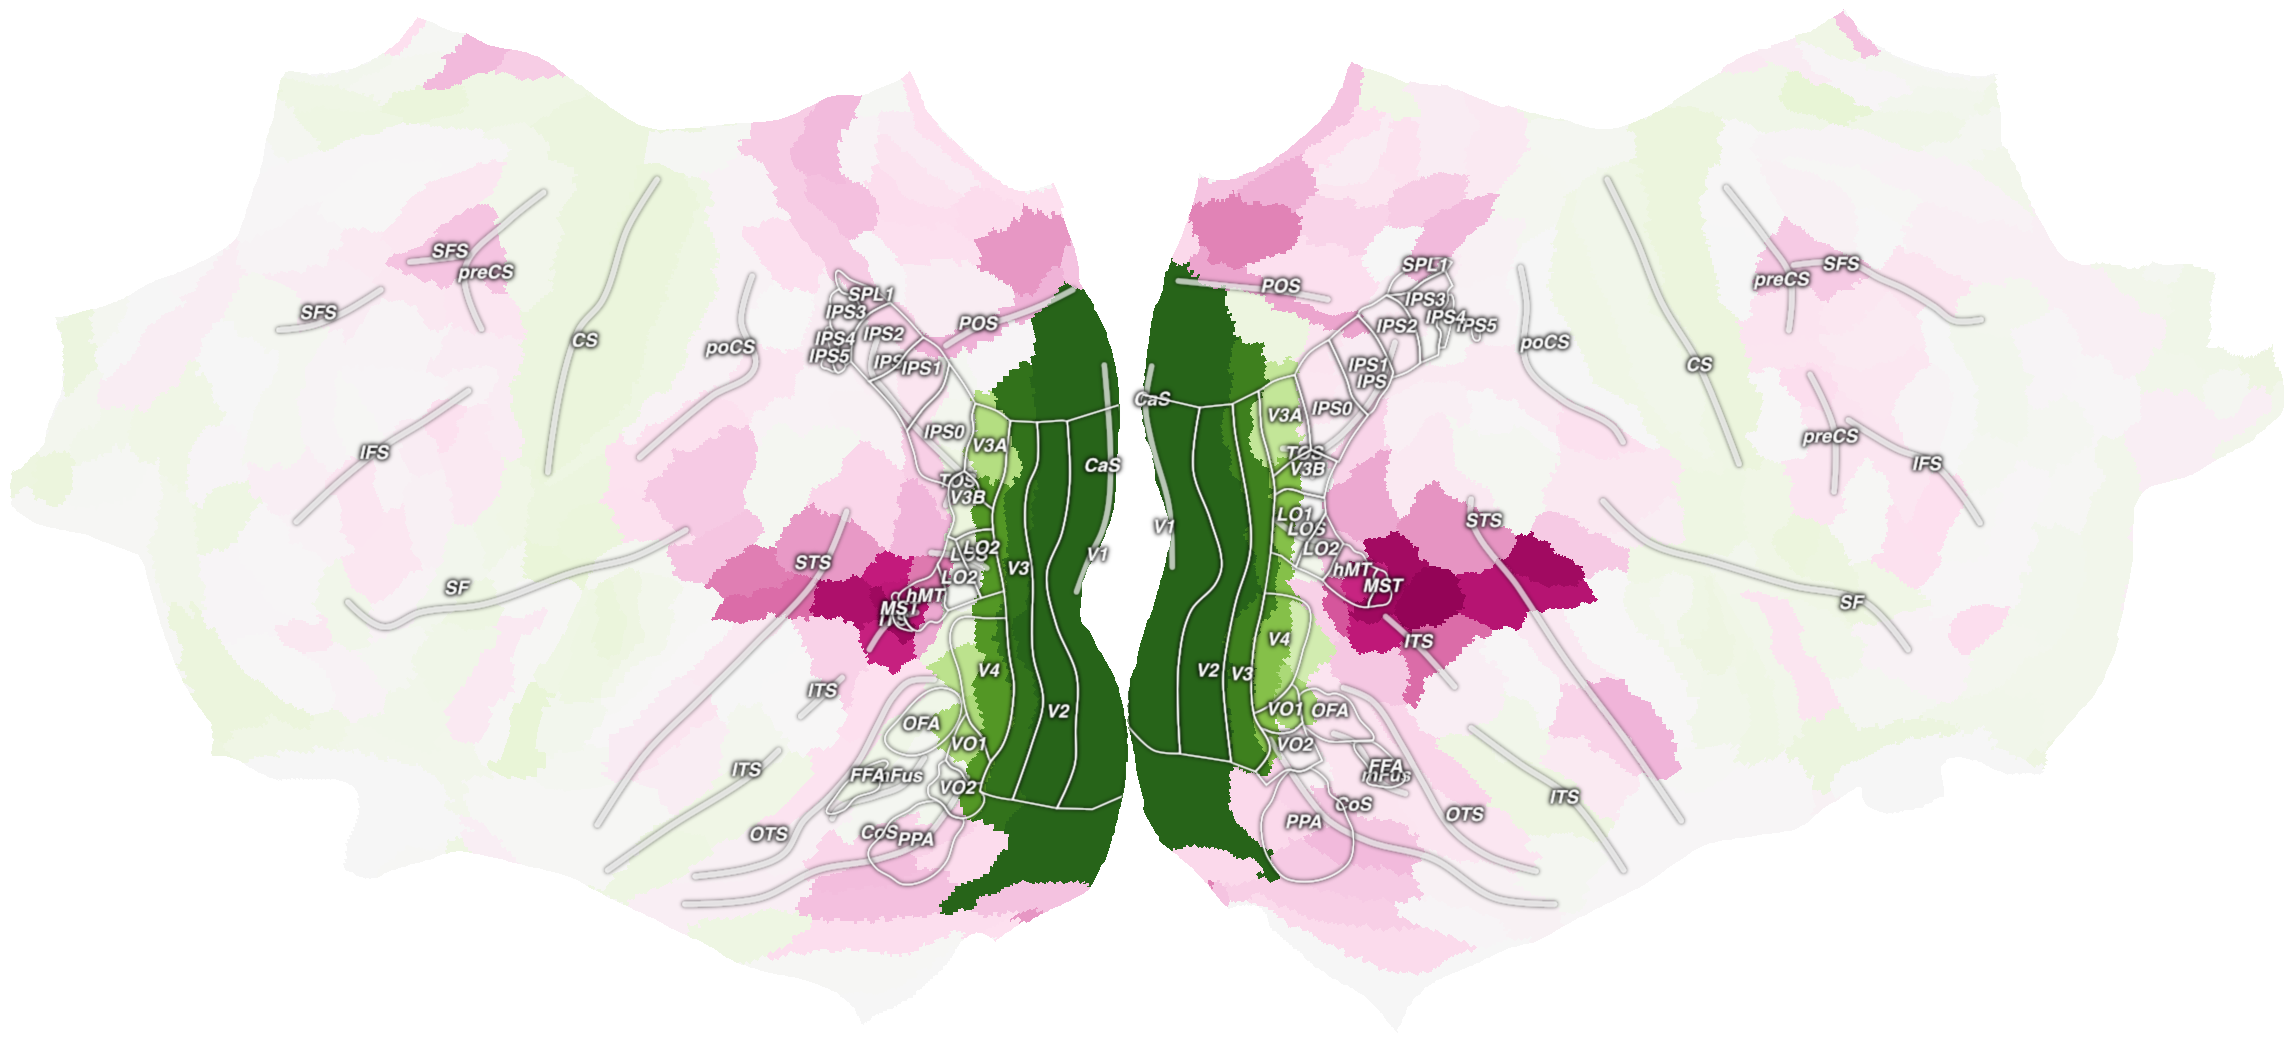

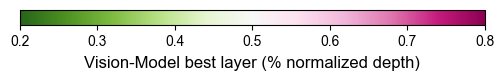

In [ ]:
output_file = output / f"04_vision-model_depth_surface_rsa.pdf"
vmin, vmax = 0.2, 0.8

# Plot and save the figure
vertex = get_vertex(df, value_column="vision_depth", vmin=vmin, vmax=vmax, cmap="PiYG_r", default_value=0.5)
fig = cortex.quickflat.make_figure(vertex, **pycortex_options)
fig.savefig(output_file, bbox_inches="tight", transparent=True)

# Save an associate colorbar
output_file = output / f"04_vision-model_depth_cbar.pdf"
title = "Vision-Model best layer (% normalized depth)"
plot_cbar_set(title=title, filename=output_file, vmax=vmax, vmin=vmin, locator=0.1, simmetric=False, cmap="PiYG_r")
